# COPD Patient Segmentation Challenge

#### By Leonard Karsunky
April 25, 2022

The aim of this analysis is to cluster/segment COPD patients into distinct subpopulations using unsupervised learning techniques. The dataset includes 101 (imaginary) patients and 22 features (both numerical and categorical), including information on their characteristics, disease severity, and co-morbidities. Other features include measures of patients' walking ability, quality of life, anxiety and depression.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import math

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn_extra.cluster import KMedoids
import gower
from prince import FAMD
from kmodes.kprototypes import KPrototypes

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 1. Data preprocessing

#### Loading the data into a dataframe

In [2]:
df_copd = pd.read_csv('dataset.csv', index_col=0)
df_copd.head()

,ID,AGE,PackHistory,COPDSEVERITY,MWT1,MWT2,MWT1Best,FEV1,FEV1PRED,FVC,...,SGRQ,AGEquartiles,copd,gender,smoking,Diabetes,muscular,hypertension,AtrialFib,IHD
1,58,77,60.0,SEVERE,120.0,120.0,120.0,1.21,36.0,2.40,...,69.55,4,3,1,2,1,0,0,1,0
2,57,79,50.0,MODERATE,165.0,176.0,176.0,1.09,56.0,1.64,...,44.24,4,2,0,2,1,0,0,1,1
3,62,80,11.0,MODERATE,201.0,180.0,201.0,1.52,68.0,2.30,...,44.09,4,2,0,2,1,0,0,1,0
4,145,56,60.0,VERY SEVERE,210.0,210.0,210.0,0.47,14.0,1.14,...,62.04,1,4,1,2,0,0,1,1,0
5,136,65,68.0,SEVERE,204.0,210.0,210.0,1.07,42.0,2.91,...,75.56,1,3,1,2,0,1,1,0,0


In [3]:
print(df_copd.columns)
print(f'\nNumber of features/variables in our dataset: {len(df_copd.columns)-1}')
# We do not include the first column since it is simply the ID list and not a feature

Index(['ID', 'AGE', 'PackHistory', 'COPDSEVERITY', 'MWT1', 'MWT2', 'MWT1Best',
       'FEV1', 'FEV1PRED', 'FVC', 'FVCPRED', 'CAT', 'HAD', 'SGRQ',
       'AGEquartiles', 'copd', 'gender', 'smoking', 'Diabetes', 'muscular',
       'hypertension', 'AtrialFib', 'IHD'],
      dtype='object')

Number of features/variables in our dataset: 22


We can notice immediately that some features such as 'copd' are redundant since it is the same as COPDSEVERITY in numerical form.

#### Plotting the distribution of continuous variables

In [4]:
cont_var = df_copd.columns.to_list()
discrete_var = ['ID','COPDSEVERITY','AGEquartiles','copd','gender','smoking',\
                'Diabetes','muscular','hypertension','AtrialFib','IHD']
for i in range(len(discrete_var)):
    cont_var.remove(discrete_var[i])

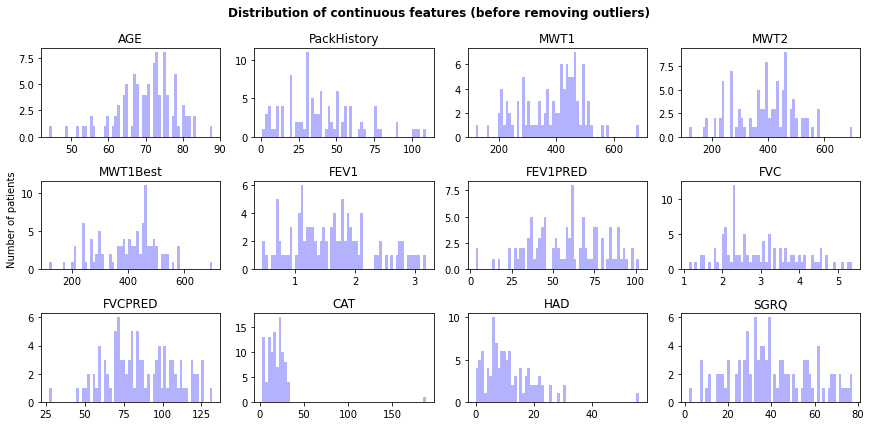

In [5]:
fig, ax = plt.subplots(3, 4, figsize=(12,6),  sharey=False, sharex=False)

for i in range(len(cont_var)):
    row = math.floor(i/4)
    col = i % 4
    sbplt = ax[row, col]
    sbplt.ticklabel_format(axis='x', style='scientific', scilimits=(-5,5))
    sbplt.hist(df_copd[cont_var[i]], bins = 60, color='blue', alpha=0.3)
    sbplt.set_title(cont_var[i])
    
fig.suptitle('Distribution of continuous features (before removing outliers)', fontweight="bold")
fig.text(0,0.38, 'Number of patients', rotation = 90)
fig.tight_layout()

#### Removing outliers

In [6]:
print('CAT median: {:.4}, and CAT max value: {}'.format(df_copd.CAT.describe().median(), df_copd.CAT.max()))
print('HAD median: {:.4}, and HAD max value: {}'.format(df_copd.HAD.describe().median(), df_copd.HAD.max()))

CAT median: 19.01, and CAT max value: 188
HAD median: 10.59, and HAD max value: 56.2


In [7]:
# Setting outlier values to the median
df_copd.loc[df_copd.loc[df_copd['CAT']==df_copd.CAT.max()].index, 'CAT'] = df_copd.CAT.describe().median()
df_copd.loc[df_copd.loc[df_copd['HAD']==df_copd.HAD.max()].index, 'HAD'] = df_copd.HAD.describe().median()

We see that for the variables CAT and HAD there exist outlier values at 188 and 56.2, respectively. Since this is far beyond the median, we removed them and replaced them with the median for further analysis (although it would be interesting to test the robustness of our clustering algorithm to outlier values).

#### Removing duplicate patient IDs.

In [8]:
init_rows = len(df_copd)
df_copd = df_copd.drop_duplicates(subset='ID', keep='first')
final_rows = len(df_copd)
print(f'Number of rows removed: {init_rows-final_rows}')
print(f'Number of patients left: {final_rows}')

Number of rows removed: 4
Number of patients left: 97


#### Replacing NaN values

In [9]:
print(f'Number of NaN data points: {df_copd.isnull().sum().sum()}')

Number of NaN data points: 4


In [10]:
# We will replace the NaN values by the median of the column (i.e. the variable)

for i in range(len(df_copd.columns)):
    # We replace continuous NaN variables with the median and discrete ones with the minimum
    if df_copd.columns[i] in cont_var:
        df_copd[df_copd.columns[i]] = df_copd[df_copd.columns[i]].replace(np.nan, df_copd[df_copd.columns[i]].describe().median())
    else:
        df_copd[df_copd.columns[i]] = df_copd[df_copd.columns[i]].replace(np.nan, df_copd[df_copd.columns[i]].min())

#### Transforming COPDSEVERITY variable into numerical data

Some clustering algorithms can only process numerical values, therefore we are converting the COPDSEVERITY into values ranging from 0 to 3. This could work since a clustering algorithm might consider that MILD patients are more similar to MODERATE than to SEVERE, which is true in some sense. It is therefore reasonable in this case to transform these categorical values into numerical ones.

In [11]:
df_copd = df_copd.drop('ID', axis=1)
df_copd_w_severity = df_copd.copy() # Keeping a copy with original COPDSEVERITY variable for algorithms below

df_copd['COPDSEVERITY'] = df_copd['COPDSEVERITY'].replace('MILD', 0)
df_copd['COPDSEVERITY'] = df_copd['COPDSEVERITY'].replace('MODERATE', 1)
df_copd['COPDSEVERITY'] = df_copd['COPDSEVERITY'].replace('SEVERE', 2)
df_copd['COPDSEVERITY'] = df_copd['COPDSEVERITY'].replace('VERY SEVERE', 3)

#### Normalizing the data

It is also important to normalize the data (using min-max normalization so that everything lies between 0 and 1) since this could severely skew our clustering results.

In [12]:
df_copd = (df_copd - df_copd.min())/(df_copd.max() - df_copd.min())

## 2. Clustering and Dimensionality Reduction

Now that our data is extracted and cleaned, we can move on to our clustering algorithms.

Obviously, since some features are already categorical, it would be very easy to simply cluster our patients using those features (e.g. to their COPD severity). However, this would omit the information from all other features and would therefore not be a wise choice.

This dataset contains a mix of both continuous and discrete variables, however most popular clustering algorithms such as K-Means are only suitable for one type of data. We will therefore try to find the most appropriate algorithm given our dataset.

Due to the *curse of dimensionality* of our 22-feature space (where the distance between the data points and the origin of the coordinate system grows as a square root of the number of dimensions causing you to lose structure), we would ideally like to take the high-dimensional feature vectors we have for each patient and embed them into a lower-dimensional latent space where some distance measure can define similarity between them.

### K-Means

K-Means works well on large datasets with numerical features, uniform cluster size, and where clusters are convex and isotropic “blobs”. However, in our case, we do not satisfy any of these properties. But it is still worth trying the generic approach and see what it gets us as a baseline.

In [13]:
def plot_sse(features_X, start=2, end=11):
    sse = []
    for k in range(start, end):
        # Assign the labels to the clusters
        kmeans = KMeans(n_clusters=k, random_state=10).fit(features_X)
        sse.append({'k': k, 'sse': kmeans.inertia_})

    sse = pd.DataFrame(sse)
    plt.plot(sse.k, sse.sse)
    plt.xlabel('K')
    plt.ylabel('Sum of Squared Errors')

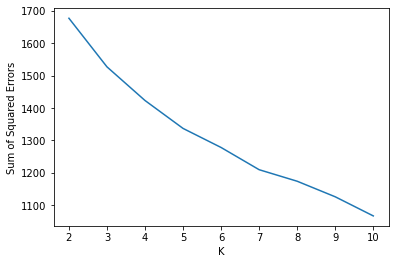

In [14]:
scaled_features = StandardScaler().fit(df_copd).transform(df_copd)
plot_sse(scaled_features)

As predicted, the Elbow method does not yield any promising results.. This is surely not the best method for clustering this data (or perhaps there is only one group in this data to begin with).

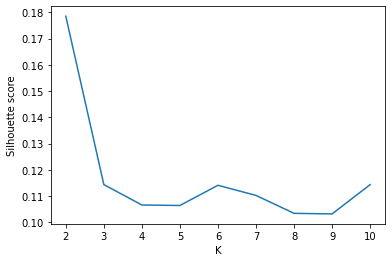

In [15]:
silhouettes = []

# Trying multiple k
for k in range(2, 11):
    # Clustering the data and assigning the labels
    labels = KMeans(n_clusters=k, random_state=10).fit_predict(scaled_features)
    # Calculating Silhouette score
    score = silhouette_score(scaled_features, labels)
    silhouettes.append({'k': k, 'score': score})
    
silhouettes = pd.DataFrame(silhouettes)

plt.plot(silhouettes.k, silhouettes.score)
plt.xlabel('K')
plt.ylabel('Silhouette score')
plt.show()

How to select K in K-means? The silhouette score seems to indicate that K=3 is a good tradeoff between the number of clusters and cohesion/separation, with the lowest value being at K=5.

### Low dimensional visualization

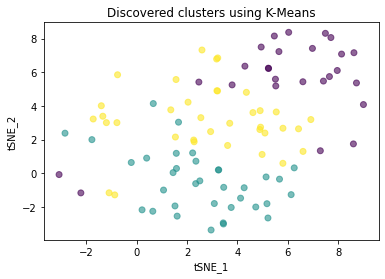

In [16]:
copd_reduced_tsne = TSNE(n_components=2, random_state=0).fit_transform(scaled_features)

labels = KMeans(n_clusters=3, random_state=0).fit_predict(scaled_features)

plt.scatter(copd_reduced_tsne[:,0], copd_reduced_tsne[:,1], c=labels, alpha=0.6)
plt.title('Discovered clusters using K-Means')
plt.xlabel('tSNE_1')
plt.ylabel('tSNE_2')
plt.show()

As we can see, using K-Means (with t-SNE for visualization) to cluster our patient data did not indicate any clear clusters or groups within the data. Indeed, the Euclidian distance metric used during K-Means is not suitabled for our multi-modal data. However, at least the different colors are grouped closely together.

Perhaps in high-dimensional space and with independantly distributed features (i.e. no correlation) it is typical that the pairwise distances between any and all points becomes very small. This could well be a problem for our data set with categorical features. We could also check during preprocessing whether our 22 variables are actually correlated in some respect (using Pearson's correlation coefficient).

Had this shown promise, we could have used association tests or box plots to interpret and assess the clusters. We can also simply analyze the statistical summaries of each cluster and assess whether it makes sense for our purpose or not (e.g. we might find one group is SEVERE COPD x AGE>70 x MALE x etc..).

### K-Prototype

K-Modes is a similar clustering algorithm that was developed as an alternative to K-Means for categorical data and is just as efficient. However, this is also solely focused on one type of data.

In light of this, K-Prototype is an agile clustering algorithm based on partitioning that can handle both categorical and numerical data.

In [ ]:
kprot_data = df_copd_w_severity.copy()

categorical_columns = [2]

#Elbow plot with cost (will take a LONG time)
costs = []
n_clusters = []
clusters_assigned = []

for i in range(2, 10):
    try:
        kproto = KPrototypes(n_clusters = i, init='Cao', verbose=2)
        clusters = kproto.fit_predict(kprot_data, categorical=categorical_columns)
        costs.append(kproto.cost_)
        n_clusters.append(i)
        clusters_assigned.append(clusters)
    except:
        print(f"Can't cluster with {i} clusters")
        
plt.scatter(x=n_clusters, y=costs)
plt.show()

(GO TO BOTTOM of previous cell to see graph)

Looking at the elbow plot, we will choose 3 clusters (although it is hard to choose).

In [18]:
#K-Prototype clustering with 3 clusters
kproto = KPrototypes(n_clusters = 3, init='Cao', n_jobs = 4)
clusters = kproto.fit_predict(kprot_data, categorical=categorical_columns)

#Prints the count of each cluster group
pd.Series(clusters).value_counts()

2    50
0    26
1    21
dtype: int64

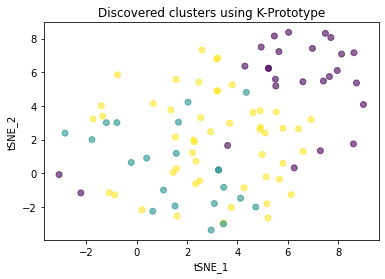

In [19]:
plt.scatter(copd_reduced_tsne[:,0], copd_reduced_tsne[:,1], c=clusters, alpha=0.6)
plt.title('Discovered clusters using K-Prototype')
plt.xlabel('tSNE_1')
plt.ylabel('tSNE_2')
plt.show()

### Gower Similarity metric

Gower’s distance is a non-Euclidian metric used to measure the similarity between two data points that contain both numeric and categorical variables and is therefore well suited for mixed datasets. It works by applying different measures of similarity for the each data type, i.e. the Manhattan distance for numerical variables and the Jaccard distance for discrete variables.

Once the Gower matrix is calculated for each pair of data points, it can be used as a distance metric for different clustering algorithms such as hierarchical agglomerative clustering or K-Means. Note that the gower package uses Gower Dissimilarity (i.e. 1 - GS).

When we fit the K-Means algorithm, instead of introducing the dataset with our data, we will introduce the matrix of distances that we have calculated.

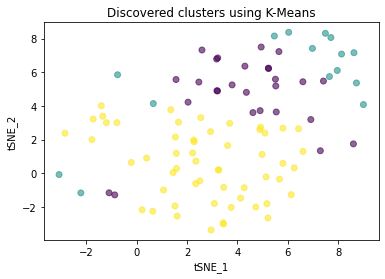

In [20]:
distance_matrix = gower.gower_matrix(df_copd_w_severity)

labels = KMeans(n_clusters=3, random_state=0).fit_predict(distance_matrix)

plt.scatter(copd_reduced_tsne[:,0], copd_reduced_tsne[:,1], c=labels, alpha=0.6)
plt.title('Discovered clusters using K-Means')
plt.xlabel('tSNE_1')
plt.ylabel('tSNE_2')
plt.show()

Although not ideal, it does separate different cluster regions quite appropriately.

In [21]:
df_copd_w_clusters = df_copd_w_severity.copy()

df_copd_w_clusters['cluster'] = labels
df_copd_w_clusters.head()

,AGE,PackHistory,COPDSEVERITY,MWT1,MWT2,MWT1Best,FEV1,FEV1PRED,FVC,FVCPRED,...,AGEquartiles,copd,gender,smoking,Diabetes,muscular,hypertension,AtrialFib,IHD,cluster
1,77,60.0,SEVERE,120.0,120.0,120.0,1.21,36.0,2.40,98,...,4,3,1,2,1,0,0,1,0,1
2,79,50.0,MODERATE,165.0,176.0,176.0,1.09,56.0,1.64,65,...,4,2,0,2,1,0,0,1,1,1
3,80,11.0,MODERATE,201.0,180.0,201.0,1.52,68.0,2.30,86,...,4,2,0,2,1,0,0,1,0,1
4,56,60.0,VERY SEVERE,210.0,210.0,210.0,0.47,14.0,1.14,27,...,1,4,1,2,0,0,1,1,0,1
5,65,68.0,SEVERE,204.0,210.0,210.0,1.07,42.0,2.91,98,...,1,3,1,2,0,1,1,0,0,1


It is very interesting to add the results of the cluster (i.e. labels) to the original dataframe to be able to interpret the results. This gives us interesting insights as to the clustering metric and the important of some features over others.

These results would allow us to know the different groups into which our customers are divided. Thus, we could carry out specific actions on them, such as specific medical prognosis, etc..

### Factor Analysis of Mixed Data

The FAMD algorithm can be seen as a combination of PCA and MCA (multiple correspondence analysis) techniques and it popular for datasets containing both categorical and numerical values (PCA for numerical, MCA for categorical).

A factor map is created with similar profiles lying close to each other. For creating labels/coloring, it is possible to color the individual data points using any of the qualitative variables in the initial dataframe (here we chose COPD Severity, but this can be changed easily).

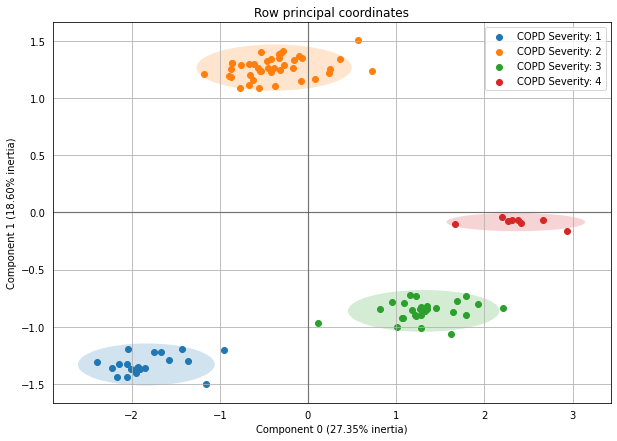

In [22]:
famd = FAMD(n_components =2, n_iter = 3, random_state = 101)

scaled_features_famd = df_copd_w_severity.copy()
famd.fit(scaled_features_famd)
famd.transform(scaled_features_famd)
famd.plot_row_coordinates(scaled_features_famd, figsize=(10, 7),\
                          color_labels=['COPD Severity: {}'.format(t) for t in scaled_features_famd['copd']])
plt.show()

This method seems to work quite well and there are clearly distinct clusters with few outliers, with 27% of variability explained by component 0 and over 18% by component 1. Although perhaps this is mostly due to the COPDSEVERITY variable being treated as the only "categorical" feature and therefore skewing the results in that way.

## Conclusion

In this small analysis, we used several unsupervised learning algorithms utilizing various distance metrics (Euclidian and non-Euclidian) to cluster patients with chronic obstructive pulmonary disease (COPD) that includes 22 features with both categorical and numerical features, including K-Means, K-Prototype and Factor Analysis of Mixed Data.

While most of the analysis can be seen throughout the notebook, most of the clustering efforts did not yield very promising results as we are sometimes used to seeing (except for FAMD which is biased due to the single categorical feature). These techniques are also very sensitive to initialization and require clusters to have convex shapes. Our low-dimensional embedding is also not creating any "nice" visual separations of our data into distinct clusters. However, most of the labels/clusters were well colored, i.e. with no overlap and clear region delineations, proving that some successful clustering of patients was achieved.

Of course, there is still a lot of analysis to be done on this dataset including data preprocessing/cleaning, as well as deeply analyzing the quality of the clustering (cardinality, magnitude), looking into more similiarity metrics and further optimizing the number of clusters. Indeed, instead of using a fixed number of predetermined clusters, we can also use hierarchical clustering methods using the Gower similarity metric, for instance.

## Going further

Another interesting task for further analysis could be to predict one variable, such as COPD severity (intuitively could be seen as the outcome variable), using a classification model such as multinomial logistic regression or a random forest classifier. If one would have access to a larger amount of data, one could also train a simple neural network (so as not to overfit) for this task which would create more powerful feature representations of the data.

Furthermore, one should be careful when implementing clustering algorithms with very large datsets, as algorithms such as hierarchical clustering has a complexity of O(N^3).